###   Urban Heat Vulnerability Index (UHVI) Script

This script uses Google Earth Engine (GEE) and various Python libraries to analyze urban heat vulnerability. It processes multiple years of open-source satellite data to create a composite **Urban Heat Vulnerability Index (UHVI)**. The UHVI is a comprehensive metric created by combining three key layers:

* **Exposure:** Represented by **Land Surface Temperature (LST)**, which quantifies the intensity of heat.
* **Sensitivity:** Measured by **Normalized Difference Vegetation Index (NDVI)**, where a lack of vegetation increases vulnerability.
* **Adaptive Capacity:** Assessed using **population density** data, as higher population density can exacerbate heat impacts.

Each layer is normalized to a 0-1 scale and then summed to create a final index ranging from **0 (lowest vulnerability)** to **3 (highest vulnerability)**.

---

###  Potential Errors and Troubleshooting

1.  **`NameError: name 'aoi' is not defined`**: This error indicates that the `aoi` (Area of Interest) variable was not created. Ensure you have run the initial code block that defines your AOI (e.g., a circle or polygon) before running any other blocks.

2.  **`ee.EEException: Image.reduceRegion: The input to a reducer must be an image.`**: This often means a layer is empty. Check your filters (e.g., `filterDate`, `filterBounds`, `filter(ee.Filter.lt('CLOUD_COVER', 5))`). A very strict cloud filter or a small AOI with no data could result in an empty image collection.

3.  **Values exceeding the 0-3 range (e.g., 3.2)**: If your final UHVI maxes out above 3, it's a normalization error. This happens when the min/max values used for a layer's normalization are not the absolute true min/max. The fix is to add a `.clamp(0, 1)` to each of your normalized layers before they are added together, as this ensures all values are strictly between 0 and 1.

4.  **`Dictionary has no key 'ST_B10_mean'`**: This occurs when a statistical reducer fails to produce a result, often because the image layer is empty or has no non-masked pixels within the AOI. This is related to the second point; check your input data and filters.

5.  **Plots or Maps not displaying**: If a plot or map figure is created but not shown, add a `plt.show()` (for Matplotlib plots) or ensure the `display()` function is correctly placed at the end of the block. In some environments, the last line must be the display command.

# Installations
##### _A restart of the session/runtime is required after running this cell_

In [59]:
# Install required libraries for GIS, data manipulation, and visualization
# A restart of the session/runtime is required after running this cell.

!pip install -U geemap
!pip install -U earthengine-api
!pip install -U pandas
!pip install -U geopandas
!pip install -U rasterio
!pip install -U numpy
!pip install -U matplotlib
!pip install -U contextily

print("Dependencies installed. Please restart your session/runtime now.")

Dependencies installed. Please restart your session/runtime now.


# Imports and GEE/Google Drive mount
##### _This section handles all necessary library imports and performs the initial setup for connecting to Google Earth Engine (GEE) and Google Drive._

In [64]:
# ===============================================================================
# Import Libraries
# ===============================================================================

# Standard Python libraries
import os
import requests
import zipfile
from io import BytesIO

# Data manipulation and analysis libraries
import pandas as pd
import geopandas as gpd
import numpy as np

# Remote sensing, GIS, and visualization libraries
import rasterio as rio
import matplotlib.pyplot as plt
import contextily as cx
import geemap
import ee
from google.colab import drive


# ===============================================================================
# Google Earth Engine (GEE) Authentication and Initialization
# ===============================================================================

# Define the GEE project name
ee_projectname = 'ee-andrewniehaus'

# Authenticate and initialize the Earth Engine API
# The 'try...except' block handles cases where the user might not be authenticated,
# prompting them to do so and then initializing with the specified project.
try:
    ee.Initialize()
except Exception as e:
    print("Authentication failed, attempting to re-authenticate...")
    ee.Authenticate()
    ee.Initialize(project=ee_projectname)

print("\nGoogle Earth Engine has been successfully authenticated and initialized.")


# ===============================================================================
# Google Drive Mounting and Project Directory Setup
# ===============================================================================

# Mount Google Drive to the Colab environment to enable file I/O
drive.mount('/content/drive')

# Define the path for the project results directory
project_path = '/content/drive/My Drive/urbanheatislandvulneraibilityresults'

# Check if the folder exists, and if not, create it
if not os.path.exists(project_path):
    os.makedirs(project_path)
    print(f"\nCreated folder: {project_path}")
else:
    print(f"\nFolder already exists: {project_path}")

# Change the current working directory to the project folder for easier file management
os.chdir(project_path)
print(f"Current working directory changed to: {os.getcwd()}")

Authentication failed, attempting to re-authenticate...

Google Earth Engine has been successfully authenticated and initialized.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Folder already exists: /content/drive/My Drive/urbanheatislandvulneraibilityresults
Current working directory changed to: /content/drive/My Drive/urbanheatislandvulneraibilityresults


In [65]:
import os
import ee
import geemap
import pandas as pd
import geopandas as gpd
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx



import os
import requests
import zipfile
from io import BytesIO
from google.colab import drive

In [66]:
ee_projectname = 'ee-andrewniehaus'

# Authenticate and initialize Earth Engine
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project=ee_projectname)

print("Google Earth Engine has been successfully authenticated and initialized.")

Google Earth Engine has been successfully authenticated and initialized.


In [67]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to our project directory in Google Drive
project_path = '/content/drive/My Drive/urbanheatislandvulneraibilityresults'

# Check if the folder exists, if not, create it
if not os.path.exists(project_path):
    os.makedirs(project_path)
    print(f"Created folder: {project_path}")
else:
    print(f"Folder already exists: {project_path}")

# Change the working directory to our new project folder
os.chdir(project_path)
print(f"Current working directory changed to: {os.getcwd()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folder already exists: /content/drive/My Drive/urbanheatislandvulneraibilityresults
Current working directory changed to: /content/drive/My Drive/urbanheatislandvulneraibilityresults


# AOI
##### _This section sets up the Area of Interest (AOI)_

In [68]:
# ===============================================================================
# Define and Create the AOI
# ===============================================================================

# --- 1. Define Variables ---
# These variables can be easily changed to define a new AOI.
# Coordinates are in [longitude, latitude] format.
center_coordinates = [-77.0369, 38.9072]  # Default: Washington, D.C.
radius_miles = 5                         # Radius in miles, adjustable by the user.

# --- 2. Convert Radius to Meters ---
# The Earth Engine buffer function requires the radius to be in meters.
# 1 mile is approximately 1609.34 meters.
radius_meters = radius_miles * 1609.34
print(f"Defining AOI: Centered at {center_coordinates} with a radius of {radius_miles} miles.")

# --- 3. Create GEE Geometry ---
# Create an Earth Engine Point object from the center coordinates.
center_point = ee.Geometry.Point(center_coordinates)

# Create the circular AOI by applying a buffer (in meters) to the point.
aoi = center_point.buffer(radius_meters)

# ===============================================================================
# Visualize the AOI
# ===============================================================================

# --- 4. Initialize and Display the Map ---
# Create an interactive geemap object, centered on the AOI's coordinates.
# The 'zoom' level can be adjusted to fit the AOI.
Map = geemap.Map(center=[center_coordinates[1], center_coordinates[0]], zoom=10)
Map.add_basemap("Esri.WorldTopoMap") # Add a topographic basemap for context.

# --- 5. Add AOI Layer to the Map ---
# Add the circular AOI as a colored layer on the map for visual confirmation.
# The dictionary defines the style (e.g., color, line width) of the layer.
Map.addLayer(aoi, {'color': 'red', 'width': 2}, 'AOI Circle')

# --- 6. Center the Map on the AOI ---
# Adjust the map view to automatically fit the entire AOI within the display.
Map.centerObject(aoi, zoom=10)

# --- 7. Final Output ---
# Display the final map and a confirmation message to the user.
display(Map)
print(f"\nAOI has been set. The variable 'aoi' is ready for use in subsequent analysis.")

Defining AOI: Centered at [-77.0369, 38.9072] with a radius of 5 miles.


Map(center=[38.90720825501003, -77.03689970581686], controls=(WidgetControl(options=['position', 'transparent_…


AOI has been set. The variable 'aoi' is ready for use in subsequent analysis.


# Exposure
##### _This section calculates exposure to Urban Heat Island effect through Landsat Land Surface Temperature observations_

In [69]:
# ===============================================================================
# GEE Data Processing: Create a Multi-Year LST Composite
# ===============================================================================

# --- 1. Load and Merge Landsat Collections ---
# Load Landsat 8 and 9 Surface Temperature (LST) collections. We combine them
# to maximize the number of available cloud-free images over our time period.
landsat8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
landsat9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')
landsat_collection = landsat8.merge(landsat9)

# --- 2. Filter Imagery by Date, Location, and Cloud Cover ---
# Define the years for the analysis.
start_year = 2020
end_year = 2023

# Create an empty collection to store filtered images from all years.
all_summer_images = ee.ImageCollection([])

# Loop through each year to filter the collection.
for year in range(start_year, end_year + 1):
    # Define the start and end dates for the summer season (June 1 to August 31).
    start_date = f'{year}-06-01'
    end_date = f'{year}-08-31'

    # Filter the Landsat collection based on three criteria:
    # 1. Date range (summer season)
    # 2. Geographic bounds (our AOI)
    # 3. Cloud cover (less than 5% to ensure data quality)
    summer_collection_year = landsat_collection.filterDate(start_date, end_date) \
                                               .filterBounds(aoi) \
                                               .filter(ee.Filter.lt('CLOUD_COVER', 5))

    # Add the filtered images from the current year to the main collection.
    all_summer_images = all_summer_images.merge(summer_collection_year)

# Get the total number of images found after filtering.
num_images = all_summer_images.size().getInfo()
print(f"Number of cloudless images found from {start_year} to {end_year}: {num_images}")

if num_images == 0:
    print("No images were found. Consider expanding the date range or relaxing the cloud filter.")


# --- 3. Create the LST Composite and Convert to Celsius ---
# Select the 'ST_B10' band (Surface Temperature) and create a median composite.
# The median is robust against outliers and noise.
composite_lst = all_summer_images.select('ST_B10').median()

# Apply the Landsat scaling formula and convert from Kelvin to Celsius.
# LST (°C) = (ST_B10 * 0.00341802) + 149.0 - 273.15
composite_lst = composite_lst.multiply(0.00341802).add(149.0)
composite_lst_celsius = composite_lst.subtract(273.15)

# Clip the composite image to the boundaries of our AOI.
composite_lst_clipped = composite_lst_celsius.clip(aoi)


# --- 4. Create and Apply a Water Mask (using MNDWI) ---
# The Modified Normalized Difference Water Index (MNDWI) helps remove water.
# It is calculated as (Green - SWIR) / (Green + SWIR).
def calculate_mndwi(image):
    """Calculates MNDWI for a single Landsat image."""
    green = image.select('SR_B3')
    swir = image.select('SR_B6')
    mndwi = green.subtract(swir).divide(green.add(swir))
    return image.addBands(mndwi.rename('MNDWI'))

# Apply the MNDWI function to all filtered images.
mndwi_collection = all_summer_images.map(calculate_mndwi)

# Create a median composite of the MNDWI results.
mndwi_composite = mndwi_collection.select('MNDWI').median()

# Create a binary mask where MNDWI > 0 is considered water.
water_mask = mndwi_composite.gt(0)

# Apply the inverse of the water mask to the LST image, setting water pixels to null.
lst_masked = composite_lst_clipped.updateMask(water_mask.Not())


# --- 5. Visualize the Final LST Image ---
# Define the color palette and value range for visualization.
lst_vis_params = {
    'min': 25.0,
    'max': 45.0,
    'palette': ['blue', 'cyan', 'green', 'yellow', 'orange', 'red']
}

# Initialize a new geemap map and add the basemap.
Map = geemap.Map(center=[center_coordinates[1], center_coordinates[0]], zoom=12)
Map.add_basemap("Esri.WorldTopoMap")

# Add the final, water-masked LST layer to the map.
Map.addLayer(lst_masked, lst_vis_params, 'Water-Masked LST Composite')

# Add a color bar legend to the map for better interpretation.
Map.add_colorbar(lst_vis_params, label="Land Surface Temperature (°C)")

# Display the map and print a confirmation message.
display(Map)
print("Multi-year, water-masked Land Surface Temperature composite image has been successfully created and displayed.")

Number of cloudless images found from 2020 to 2023: 6


Map(center=[38.9072, -77.0369], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topr…

Multi-year, water-masked Land Surface Temperature composite image has been successfully created and displayed.


Calculating LST summary statistics...

--- LST Composite Summary Statistics ---
Time Period: 2020-2023, Summer (Jun-Aug)
AOI: Circular AOI
Number of Images Used: 6
------------------------------------------


,Temperature (°C)
Mean LST,40.1
Median LST,40.7
Minimum LST,28.5
Maximum LST,55.4
Standard Deviation,4.2


------------------------------------------

Generating LST histogram...


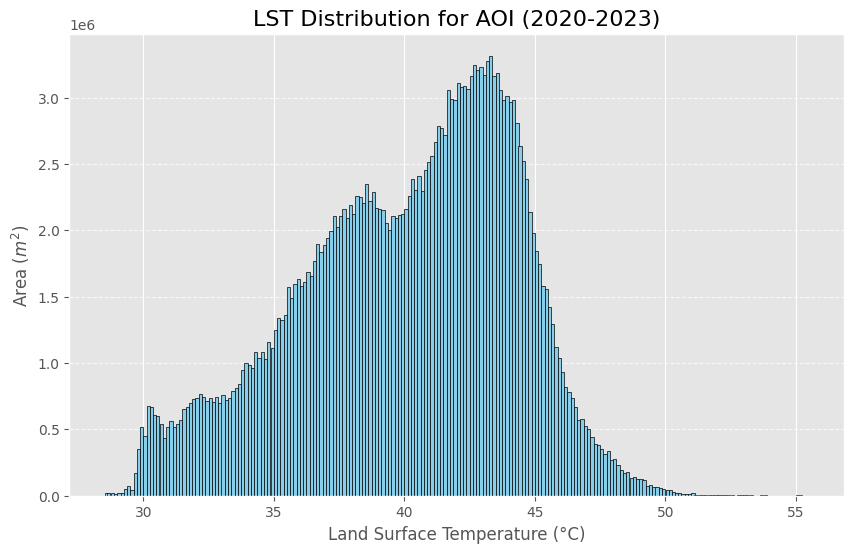

In [70]:
# ===============================================================================
# Statistical Analysis of the LST Composite
# ===============================================================================

print("Calculating LST summary statistics...")

# --- 1. Calculate Summary Statistics ---
# Use the Earth Engine `reduceRegion` function to compute multiple statistics
# (mean, median, min, max, stdDev) for the LST image over the AOI.
# The `scale` parameter ensures calculations are performed at a 30-meter resolution.
stats = lst_masked.reduceRegion(
    reducer=ee.Reducer.mean() \
             .combine(ee.Reducer.median(), None, True) \
             .combine(ee.Reducer.min(), None, True) \
             .combine(ee.Reducer.max(), None, True) \
             .combine(ee.Reducer.stdDev(), None, True),
    geometry=aoi,
    scale=30,
    maxPixels=1e9  # Allows processing of a large number of pixels
)

# Convert the GEE result to a Python dictionary for easier handling.
stats_dict = stats.getInfo()

# --- 2. Create a Pandas DataFrame for Presentation ---
if not stats_dict or not any(stats_dict.values()):
    # This check handles cases where the AOI has no valid, non-masked pixels.
    print("Warning: Statistics could not be computed. The AOI may contain only masked or null pixels.")
else:
    # Extract and format the values for readability.
    mean_val = stats_dict.get('ST_B10_mean')
    median_val = stats_dict.get('ST_B10_median')
    min_val = stats_dict.get('ST_B10_min')
    max_val = stats_dict.get('ST_B10_max')
    stdDev_val = stats_dict.get('ST_B10_stdDev')

    # A check to correct for a possible GEE bug where min and max are swapped.
    if min_val is not None and max_val is not None:
        corrected_min = min(min_val, max_val)
        corrected_max = max(min_val, max_val)
    else:
        # Fallback if a value is None.
        corrected_min, corrected_max = min_val, max_val

    # Create a new, clean dictionary for the DataFrame.
    summary_stats = {
        'Mean LST': [f"{mean_val:.1f}"],
        'Median LST': [f"{median_val:.1f}"],
        'Minimum LST': [f"{corrected_min:.1f}"],
        'Maximum LST': [f"{corrected_max:.1f}"],
        'Standard Deviation': [f"{stdDev_val:.1f}"]
    }

    # Create the final DataFrame and format it for a clean output table.
    stats_df = pd.DataFrame(summary_stats).T.rename(columns={0: 'Temperature (°C)'})

    print("\n--- LST Composite Summary Statistics ---")
    print(f"Time Period: {start_year}-{end_year}, Summer (Jun-Aug)")
    print("AOI: Circular AOI")
    print(f"Number of Images Used: {num_images}")
    print("------------------------------------------")
    display(stats_df.style.set_caption("Summary Statistics Table"))
    print("------------------------------------------")


# ===============================================================================
# Generate and Display LST Histogram
# ===============================================================================
print("\nGenerating LST histogram...")

# --- 1. Extract Histogram Data from the LST Composite ---
# Use `reduceRegion` with the `ee.Reducer.histogram` to get the distribution of pixel values.
histogram_data = lst_masked.reduceRegion(
    reducer=ee.Reducer.histogram(256),  # 256 bins for the histogram
    geometry=aoi,
    scale=30,  # Ensure consistency with LST resolution
    maxPixels=1e9
)
histogram_info = histogram_data.getInfo()

# --- 2. Plot the Histogram with Area on the Y-axis ---
if 'ST_B10' in histogram_info and histogram_info['ST_B10']['histogram']:
    # Extract the bin counts and their corresponding temperature means.
    counts = np.array(histogram_info['ST_B10']['histogram'])
    bins = histogram_info['ST_B10']['bucketMeans']
    bucket_width = histogram_info['ST_B10']['bucketWidth']

    # Convert pixel counts to physical area. Landsat pixels are 30m x 30m.
    area_per_pixel_m2 = 900
    area_m2 = counts * area_per_pixel_m2

    # Plot the histogram using Matplotlib.
    plt.figure(figsize=(10, 6))
    plt.bar(bins, area_m2, width=bucket_width, color='skyblue', edgecolor='black', linewidth=0.5, align='center')
    plt.title(f'LST Distribution for AOI ({start_year}-{end_year})', fontsize=16)
    plt.xlabel('Land Surface Temperature (°C)', fontsize=12)
    plt.ylabel('Area ($m^2$)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("Warning: Histogram data could not be retrieved. Please check if there are non-null pixels in the AOI.")

# Sensitivity
##### _This section assesses sensitivity to Urban Heat Island effect through population density_

In [71]:
# ===============================================================================
# Load and Visualize Population Data
# ===============================================================================

# --- 1. Load the GHS-POP Dataset ---
# The GHS-POP dataset provides population counts, which is a key variable for
# assessing urban heat vulnerability. We'll use the most recent 2020 data.
print("Loading GHS-POP 2020 dataset...")
ghs_pop_2020 = ee.Image("JRC/GHSL/P2023A/GHS_POP/2020")

# Clip the population data to the boundaries of our AOI.
ghs_pop_2020_clipped = ghs_pop_2020.clip(aoi)

# --- 2. Define Visualization and Display the Map ---
# Define a color palette for visualizing population density.
# The 'min' and 'max' values represent population per pixel (250m x 250m).
pop_vis_params = {
    'min': 0,
    'max': 200,  # A max value of 200 people per pixel is used for visualization.
    'palette': ['yellow', 'orange', 'red', 'purple']
}

# Initialize a new geemap map, centered on the AOI.
Map = geemap.Map(center=[center_coordinates[1], center_coordinates[0]], zoom=12)
Map.add_basemap("Esri.WorldTopoMap")

# Add the population layer to the map. We select the 'population_count' band.
Map.addLayer(ghs_pop_2020_clipped.select('population_count'), pop_vis_params, 'Population Density')

# Add the AOI circle as an outline for geographic context.
Map.addLayer(aoi, {'color': 'white', 'width': 2}, 'AOI')

# Add a color bar legend for the population layer.
Map.add_colorbar(pop_vis_params, label="Population (per pixel)")

# Display the final map and a confirmation message.
display(Map)
print("GHS-POP population density data has been loaded and displayed for the AOI.")

Loading GHS-POP 2020 dataset...


Map(center=[38.9072, -77.0369], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topr…

GHS-POP population density data has been loaded and displayed for the AOI.


Calculating population density summary statistics...
Raw statistics from GEE: {'population_count_max': 602.1439819335938, 'population_count_mean': 53.524045839234915, 'population_count_median': 33.998749102019985, 'population_count_min': 0.00010477040268597193, 'population_count_stdDev': 60.44882872779383}

--- GHS-POP Population Density Summary Statistics (Excluding Zeros) ---
------------------------------------------


,Population (per 250m pixel)
Mean Population,54
Median Population,34
Minimum Population,0.0001
Maximum Population,602
Standard Deviation,60


------------------------------------------

Generating population histogram...


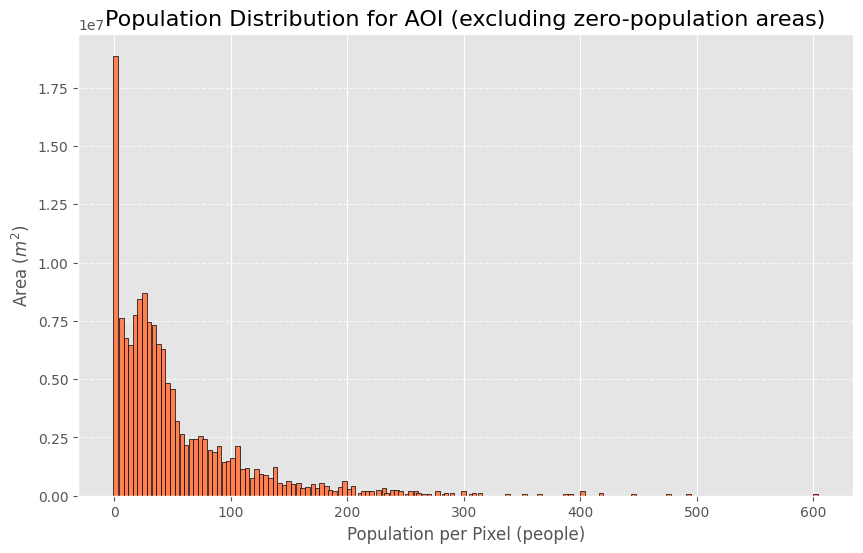

In [72]:
# ===============================================================================
# Population Data Statistical Analysis
# ===============================================================================

print("Calculating population density summary statistics...")

# --- 1. Create a masked image to exclude zero-population pixels ---
# We will perform our statistical analysis on this new, temporary image.
pop_data_masked = ghs_pop_2020_clipped.updateMask(ghs_pop_2020_clipped.gt(0))

# --- 2. Calculate Summary Statistics for Populated Areas ---
# Use `reduceRegion` to compute various statistics on the masked population data.
pop_stats = pop_data_masked.reduceRegion(
    reducer=ee.Reducer.mean() \
             .combine(ee.Reducer.median(), None, True) \
             .combine(ee.Reducer.min(), None, True) \
             .combine(ee.Reducer.max(), None, True) \
             .combine(ee.Reducer.stdDev(), None, True),
    geometry=aoi,
    scale=250,
    maxPixels=1e9
)

# Fetch the results from Earth Engine and store them in a Python dictionary.
pop_stats_dict = pop_stats.getInfo()
print("Raw statistics from GEE:", pop_stats_dict)

# --- 3. Create a DataFrame for a simple table ---
if not pop_stats_dict or not any(pop_stats_dict.values()):
    print("\n⚠️  Warning: Statistics could not be computed. The AOI may have no valid population pixels.")
else:
    # Organize the extracted statistics into a dictionary for DataFrame creation.
    # Note: Keys are set to match the output from the `reduceRegion` call.
    summary_stats = {
        'Mean Population': [f"{pop_stats_dict.get('population_count_mean'):.0f}"],
        'Median Population': [f"{pop_stats_dict.get('population_count_median'):.0f}"],
        'Minimum Population': [f"{pop_stats_dict.get('population_count_min'):.4f}"],  # Rounded to 4 decimal places
        'Maximum Population': [f"{pop_stats_dict.get('population_count_max'):.0f}"],
        'Standard Deviation': [f"{pop_stats_dict.get('population_count_stdDev'):.0f}"]
    }

    # Create the DataFrame from the dictionary and name the column appropriately.
    stats_df = pd.DataFrame(summary_stats).T
    stats_df.columns = ['Population (per 250m pixel)']

    print("\n--- GHS-POP Population Density Summary Statistics (Excluding Zeros) ---")
    print("------------------------------------------")

    # Display the final, formatted table for a clean output.
    display(stats_df.style.set_caption("Population Density Summary (people per 250m pixel)").format(precision=1))

    print("------------------------------------------")


# ===============================================================================
# Generate and Display Population Histogram (excluding zero-population pixels)
# ===============================================================================
print("\nGenerating population histogram...")

# --- 1. Extract Histogram Data from the Population Layer ---
# Use `reduceRegion` on the masked image to get the distribution of population values.
histogram_data = pop_data_masked.reduceRegion(
    reducer=ee.Reducer.histogram(256),
    geometry=aoi,
    scale=250,
    maxPixels=1e9
)
histogram_info = histogram_data.getInfo()

# --- 2. Plot the Histogram with Area on the Y-axis ---
if 'population_count' in histogram_info and histogram_info['population_count']['histogram']:
    # Extract the bin counts, their corresponding population means, and the bucket width.
    counts = np.array(histogram_info['population_count']['histogram'])
    bins = histogram_info['population_count']['bucketMeans']
    bucket_width = histogram_info['population_count']['bucketWidth']

    # Convert pixel counts to physical area. GHS-POP pixels are 250m x 250m.
    area_per_pixel_m2 = 250 * 250
    area_m2 = counts * area_per_pixel_m2

    # Plot the histogram using Matplotlib.
    plt.figure(figsize=(10, 6))
    plt.bar(bins, area_m2, width=bucket_width, color='coral', edgecolor='black', linewidth=0.5, align='center')
    plt.title(f'Population Distribution for AOI (excluding zero-population areas)', fontsize=16)
    plt.xlabel('Population per Pixel (people)', fontsize=12)
    plt.ylabel('Area ($m^2$)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("Warning: Histogram data could not be retrieved. Please check if there are non-null pixels in the AOI.")

# Adaptive Capacity
##### _This section assesses adaptive capacity to Urban Heat Island effect through vegetation presence_

In [73]:
# ===============================================================================
# NDVI Composite Creation and Visualization
# ===============================================================================

# --- 1. Define a function to calculate NDVI ---
# The Normalized Difference Vegetation Index (NDVI) is a measure of vegetation
# greenness. It is calculated as (NIR - Red) / (NIR + Red).
# For Landsat 8/9, the Near-Infrared band is 'SR_B5' and the Red band is 'SR_B4'.
def calculate_ndvi(image):
    """
    Calculates the NDVI for a single Landsat 8/9 image.
    :param image: An ee.Image object.
    :return: The input image with a new 'NDVI' band.
    """
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    return image.addBands(ndvi)

# --- 2. Map the function and create a composite ---
# Apply the `calculate_ndvi` function to every image in our multi-year collection.
ndvi_collection = all_summer_images.map(calculate_ndvi)

# Create a single composite image from the collection using a median reducer.
# The median composite helps to reduce noise and atmospheric effects.
# The image is then clipped to the AOI for focused analysis.
ndvi_composite = ndvi_collection.select('NDVI').median().clip(aoi)

# --- 3. Define visualization parameters and display the map ---
# Define a color palette that visually represents NDVI values.
# Values range from -1 (e.g., water) to +1 (e.g., dense vegetation).
ndvi_viz = {
    'min': -1,
    'max': 1,
    'palette': ['red', 'white', 'green']
}

# Create an interactive map centered on the AOI.
Map = geemap.Map(center=aoi.centroid(1).getInfo()['coordinates'][::-1], zoom=11)

# Add the final NDVI layer to the map with the defined visualization parameters.
Map.add_layer(ndvi_composite, ndvi_viz, 'Landsat NDVI Composite 2020-2023')

# Display the map object.
display(Map)

Map(center=[38.90720825501003, -77.03689970581686], controls=(WidgetControl(options=['position', 'transparent_…

Calculating NDVI summary statistics...

--- NDVI Composite Summary Statistics ---
------------------------------------------


,NDVI Value
Mean NDVI,0.238
Median NDVI,0.248
Minimum NDVI,-0.100
Maximum NDVI,0.565
Standard Deviation,0.130


------------------------------------------

Generating NDVI histogram...


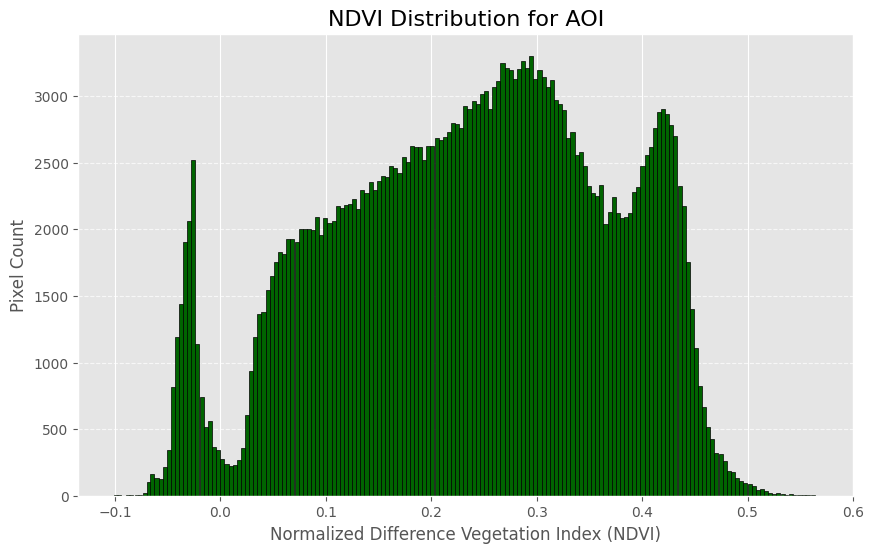

In [74]:
# ===============================================================================
# NDVI Statistical Analysis
# ===============================================================================

print("Calculating NDVI summary statistics...")

# --- 1. Calculate Summary Statistics for NDVI ---
# The `reduceRegion` function is used to compute multiple statistics on the NDVI composite.
# The `scale` is set to 30 meters to match the original Landsat pixel resolution.
ndvi_stats = ndvi_composite.reduceRegion(
    reducer=ee.Reducer.mean() \
             .combine(ee.Reducer.median(), None, True) \
             .combine(ee.Reducer.min(), None, True) \
             .combine(ee.Reducer.max(), None, True) \
             .combine(ee.Reducer.stdDev(), None, True),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
)

# Convert the Earth Engine result to a Python dictionary.
ndvi_stats_dict = ndvi_stats.getInfo()

# --- 2. Create a DataFrame for a simple table ---
if not ndvi_stats_dict or not any(ndvi_stats_dict.values()):
    print("\n⚠️  Warning: Statistics could not be computed. The AOI may have no valid NDVI pixels.")
else:
    # Organize the extracted statistics into a dictionary for the DataFrame.
    # Keys are set to match the GEE output (e.g., 'NDVI_mean').
    summary_stats = {
        'Mean NDVI': [ndvi_stats_dict.get('NDVI_mean')],
        'Median NDVI': [ndvi_stats_dict.get('NDVI_median')],
        'Minimum NDVI': [ndvi_stats_dict.get('NDVI_min')],
        'Maximum NDVI': [ndvi_stats_dict.get('NDVI_max')],
        'Standard Deviation': [ndvi_stats_dict.get('NDVI_stdDev')]
    }

    # Create the DataFrame and name the column appropriately.
    stats_df = pd.DataFrame(summary_stats).T
    stats_df.columns = ['NDVI Value']

    print("\n--- NDVI Composite Summary Statistics ---")
    print("------------------------------------------")

    # Display the formatted DataFrame.
    display(stats_df.style.set_caption("NDVI Summary Statistics").format(precision=3))

    print("------------------------------------------")


# ===============================================================================
# Generate and Display NDVI Histogram
# ===============================================================================
print("\nGenerating NDVI histogram...")

# --- 1. Extract Histogram Data ---
# Use `reduceRegion` with the `ee.Reducer.histogram` to get the distribution of NDVI values.
histogram_data = ndvi_composite.reduceRegion(
    reducer=ee.Reducer.histogram(256),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
)
histogram_info = histogram_data.getInfo()

# --- 2. Plot the Histogram with Pixel Count on the Y-axis ---
if 'NDVI' in histogram_info and histogram_info['NDVI']['histogram']:
    # Extract counts, bins, and bucket width.
    counts = np.array(histogram_info['NDVI']['histogram'])
    bins = histogram_info['NDVI']['bucketMeans']
    bucket_width = histogram_info['NDVI']['bucketWidth']

    # Plot the histogram using Matplotlib.
    plt.figure(figsize=(10, 6))
    plt.bar(bins, counts, width=bucket_width, color='darkgreen', edgecolor='black', linewidth=0.5, align='center')
    plt.title(f'NDVI Distribution for AOI', fontsize=16)
    plt.xlabel('Normalized Difference Vegetation Index (NDVI)', fontsize=12)
    plt.ylabel('Pixel Count', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("Warning: Histogram data could not be retrieved. Please check if there are non-null pixels in the AOI.")

# Vulnerability Index
##### _This section calculates the vulnerability to Urban Heat Island effect on a 0-3 scale_

In [86]:
# ===============================================================================
# Calculate and Map Urban Heat Vulnerability Index (UHVI)
# ===============================================================================

print("Calculating Urban Heat Vulnerability Index...")

# --- 1. Normalize LST to a 0-1 scale ---
lst_min = lst_stats_dict['ST_B10_min']
lst_max = lst_stats_dict['ST_B10_max']
lst_normalized = composite_lst_clipped.subtract(lst_min).divide(lst_max - lst_min).clamp(0, 1).rename('LST_norm')
print("LST layer normalized.")

# --- 2. Normalize NDVI to a 0-1 scale (inverted) ---
ndvi_min = ndvi_stats_dict['NDVI_min']
ndvi_max = ndvi_stats_dict['NDVI_max']
ndvi_normalized = ee.Image(1).subtract(ndvi_composite.subtract(ndvi_min).divide(ndvi_max - ndvi_min)).clamp(0, 1).rename('NDVI_norm')
print("NDVI layer normalized (inverted).")

# --- 3. Normalize Population to a 0-1 scale ---
pop_min = pop_stats_dict['population_count_min']
pop_max = pop_stats_dict['population_count_max']
pop_normalized = ghs_pop_2020_clipped.select('population_count').subtract(pop_min).divide(pop_max - pop_min).clamp(0, 1).rename('POP_norm')
print("Population layer normalized.")

# --- 4. Sum the normalized layers to create the final index ---
uhvi = lst_normalized.add(ndvi_normalized).add(pop_normalized).rename('UHVI')
uhvi_final = uhvi.updateMask(lst_masked.mask()).clip(aoi)
print("Final Vulnerability Index created.")

# --- 5. Visualize the final Vulnerability Index ---
# A clear color palette helps interpret the results.
uhvi_vis_params = {
    'min': 0,
    'max': 3,
    'palette': ['green', 'yellow', 'orange', 'red', 'darkred']
}

# Create a new map to display the final index.
Map = geemap.Map(center=[center_coordinates[1], center_coordinates[0]], zoom=12)
Map.add_basemap("Esri.WorldTopoMap")

# Add the final UHVI layer to the map.
Map.addLayer(uhvi_final, uhvi_vis_params, 'Urban Heat Vulnerability Index')

# Add a color bar legend for the UHVI.
Map.add_colorbar(uhvi_vis_params, label="Urban Heat Vulnerability Index (0-3)")

# Add a layer for the AOI boundary for context.
Map.addLayer(aoi, {'color': 'white', 'width': 2}, 'AOI')

# Display the map and confirmation message.
display(Map)
print("\nUrban Heat Vulnerability Index map has been successfully generated and displayed.")

Calculating Urban Heat Vulnerability Index...
LST layer normalized.
NDVI layer normalized (inverted).
Population layer normalized.
Final Vulnerability Index created.


Map(center=[38.9072, -77.0369], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topr…


Urban Heat Vulnerability Index map has been successfully generated and displayed.


Calculating UHVI summary statistics...

--- Urban Heat Vulnerability Index Summary Statistics ---
------------------------------------------


,UHVI Value
Mean UHVI,0.968
Median UHVI,0.977
Minimum UHVI,0.154
Maximum UHVI,2.473
Standard Deviation,0.363


------------------------------------------

Generating UHVI histogram...


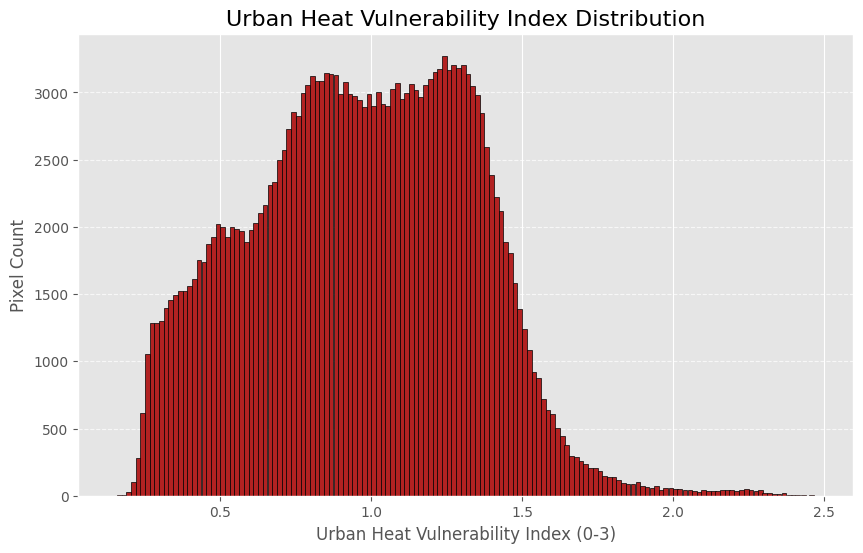

In [87]:
# ===============================================================================
# Urban Heat Vulnerability Index (UHVI) Statistical Analysis
# ===============================================================================

print("Calculating UHVI summary statistics...")

# --- 1. Calculate Summary Statistics for UHVI ---
# We use the same `reduceRegion` approach to get key statistics for our final index.
uhvi_stats = uhvi_final.reduceRegion(
    reducer=ee.Reducer.mean() \
             .combine(ee.Reducer.median(), None, True) \
             .combine(ee.Reducer.min(), None, True) \
             .combine(ee.Reducer.max(), None, True) \
             .combine(ee.Reducer.stdDev(), None, True),
    geometry=aoi,
    scale=30, # The finest scale among our input layers
    maxPixels=1e9
)

# Fetch the results from GEE and store them in a Python dictionary.
uhvi_stats_dict = uhvi_stats.getInfo()

# --- 2. Create a DataFrame for a simple table ---
if not uhvi_stats_dict or not any(uhvi_stats_dict.values()):
    print("\n⚠️  Warning: Statistics could not be computed. The AOI may have no valid UHVI pixels.")
else:
    # Extract the stats and organize into a dictionary.
    summary_stats = {
        'Mean UHVI': [uhvi_stats_dict.get('UHVI_mean')],
        'Median UHVI': [uhvi_stats_dict.get('UHVI_median')],
        'Minimum UHVI': [uhvi_stats_dict.get('UHVI_min')],
        'Maximum UHVI': [uhvi_stats_dict.get('UHVI_max')],
        'Standard Deviation': [uhvi_stats_dict.get('UHVI_stdDev')]
    }

    # Create the DataFrame and name the column appropriately.
    stats_df = pd.DataFrame(summary_stats).T
    stats_df.columns = ['UHVI Value']

    print("\n--- Urban Heat Vulnerability Index Summary Statistics ---")
    print("------------------------------------------")
    display(stats_df.style.set_caption("UHVI Summary Statistics").format(precision=3))
    print("------------------------------------------")


# ===============================================================================
# Generate and Display UHVI Histogram
# ===============================================================================
print("\nGenerating UHVI histogram...")

# --- 1. Extract Histogram Data ---
histogram_data = uhvi_final.reduceRegion(
    reducer=ee.Reducer.histogram(256),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
)
histogram_info = histogram_data.getInfo()

# --- 2. Plot the Histogram with Pixel Count on the Y-axis ---
if 'UHVI' in histogram_info and histogram_info['UHVI']['histogram']:
    # Extract counts, bins, and bucket width.
    counts = np.array(histogram_info['UHVI']['histogram'])
    bins = histogram_info['UHVI']['bucketMeans']
    bucket_width = histogram_info['UHVI']['bucketWidth']

    # Plot the histogram using Matplotlib.
    plt.figure(figsize=(10, 6))
    plt.bar(bins, counts, width=bucket_width, color='firebrick', edgecolor='black', linewidth=0.5, align='center')
    plt.title(f'Urban Heat Vulnerability Index Distribution', fontsize=16)
    plt.xlabel('Urban Heat Vulnerability Index (0-3)', fontsize=12)
    plt.ylabel('Pixel Count', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("Warning: Histogram data could not be retrieved. Please check if there are non-null pixels in the AOI.")